In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.21.5
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [22]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

In [23]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/extend/fog_dataset_extend.hdf"
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')

# df_train.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_valid.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_test.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]

# x_columns = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_linear']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_linear']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_linear']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)


['/test', '/train', '/valid']
(63311, 15)
(63311,)


In [24]:
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
valid_x_scaled = scaler.fit_transform(valid_x)
test_x_scaled  = scaler.fit_transform(test_x)

train_x_scaled[:,0:3] = train_x[:,0:3]
train_x_scaled[:,-5:-1] = train_x[:,-5:-1]
valid_x_scaled[:,0:3]   = valid_x[:,0:3]
valid_x_scaled[:,-5:-1] = valid_x[:,-5:-1]
test_x_scaled[:,0:3]    = test_x[:,0:3]
test_x_scaled[:,-5:-1]  = test_x[:,-5:-1]

In [25]:
print(np.max(train_x_scaled), np.min(train_x_scaled))

16.16436767578125 -18.0921630859375


In [26]:
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        """定义模型的层次"""
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = keras.layers.Dense(1)
    
    def call(self, input):
        """完成模型的正向计算"""
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output

In [28]:
model = WideDeepModel()
# model = keras.models.Sequential([
#     WideDeepModel(),
# ])

model.build(input_shape=(None, train_x_scaled.shape[1:][0]))
        
model.summary()
model.compile(loss="mean_squared_error",
              optimizer = keras.optimizers.SGD(0.001))

Model: "wide_deep_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             multiple                  480       
_________________________________________________________________
dense_19 (Dense)             multiple                  930       
_________________________________________________________________
dense_20 (Dense)             multiple                  46        
Total params: 1,456
Trainable params: 1,456
Non-trainable params: 0
_________________________________________________________________


In [ ]:
'''
# 函数式API 功能API
input = keras.layers.Input(shape=train_x_scaled.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
# 复合函数: f(x) = h(g(x))

concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs = [input],
                           outputs = [output])

model.summary()
model.compile(loss="mean_squared_error",
              optimizer = keras.optimizers.SGD(0.001))
'''

In [31]:
# H:/github/python/seafog/
logdir = './callbacks_reg_wd'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "sea_fog_reg_model.h5")

model_callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4),
    ]
history = model.fit(train_x_scaled, train_y, epochs=100,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = model_callbacks)

Epoch 1/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1917 - val_loss: 0.4816
Epoch 2/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1889 - val_loss: 0.4855
Epoch 3/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1863 - val_loss: 0.4843
Epoch 4/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1841 - val_loss: 0.4890
Epoch 5/100
1979/1979 [==============================] - 5s 2ms/step - loss: 0.1821 - val_loss: 0.4898
Epoch 6/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1803 - val_loss: 0.4917
Epoch 7/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1786 - val_loss: 0.4904
Epoch 8/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1769 - val_loss: 0.4985
Epoch 9/100
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1754 - val_loss: 0.4948


In [ ]:
type(history)

In [ ]:
history.history

In [ ]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [32]:
model.evaluate(test_x_scaled, test_y, verbose=0)

0.30945292115211487

* 默认wide and deep 模型 MSE 0.31

In [33]:
predictions = model(test_x_scaled).numpy()
predictions


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[0.4101022 ],
       [0.44835138],
       [0.49497485],
       ...,
       [2.443428  ],
       [2.5972388 ],
       [2.616255  ]], dtype=float32)

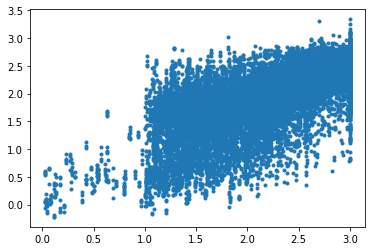

In [34]:
plt.plot(test_y, predictions,'.')
plt.show()

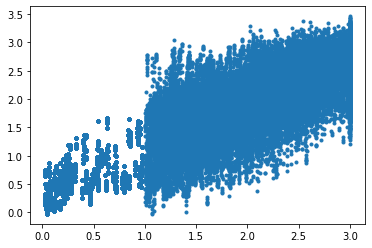

In [35]:
plt.plot(train_y,model(train_x_scaled).numpy(),'.')
plt.show()

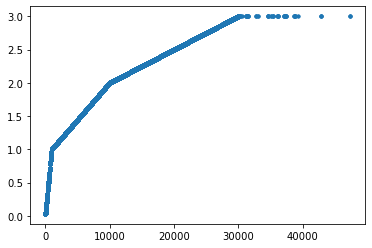

In [36]:
plt.plot(df_train['station_vis'].values,train_y,'.')
plt.show()

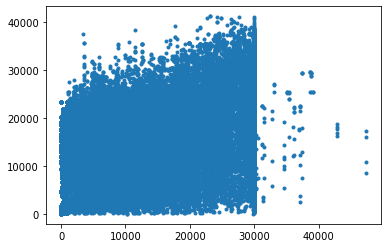

In [37]:
plt.plot(df_train['station_vis'].values,df_train['visi'],'.')
plt.show()

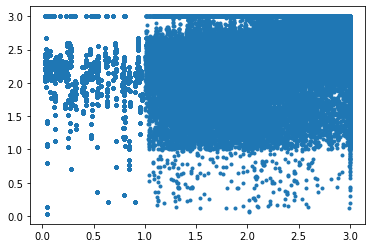

1.2369055392943231


In [38]:
plt.plot(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis)))

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()

In [ ]:
p_test[:,0]

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 